# 데이터 소개
- 월마트 매출 분석
해당 데이터셋은 휴무일, 날짜, 온도 등 따른 상점 판매에 대한 판매액을 보여주고 있고, 

10개의 특성 [휴일, 온도, 연료 가격, 경제 지표(CPI, 실업률) 및 시간 관련 특징(년, 월, 일, 요일)과 같은 요소] 및 타겟 변수 [판매액]으로 구성된 6435개의 행을 가지고 있다. 
이에 본 팀은 해당 데이터셋으로 다양한 특성들에 대한 판매액 간의 상관관계를 분석하고,
이를 시각화하며 이를 통해 어떤 요소가 더 효과적인지, 해당 요소는 판매액에 어떤 영향을 미치는지 등을 평가하고자 한다.

- 출처 : https://www.kaggle.com/code/yasserh/walmart-sales-prediction-best-ml-algorithms

## 변수 설명


- Store (상점): 상점을 식별하는 번호

- Weekly_Sales (주간 판매): 주간 전체 판매 금액

- Holiday_Flag (휴일 플래그): 휴일을 포함하는 주(1)인지 아닌지(0)를 나타내는 이진 표시기

- Temperature (온도): 주간 동안의 온도

- Fuel_Price (연료 가격): 주간 동안의 연료 비용

- CPI (소비자 물가 지수): 소비자가 상품과 서비스를 지불하는 가격 변화를 측정하는 지수-> 인플레이션의 지표

- Unemployment (실업률): 주간 동안의 실업률

- Year (년): 데이터가 기록된 연도

- Month (월): 데이터가 기록된 월

- Day (일): 데이터가 기록된 월 중 날짜

- Weekday (요일): 요일의 숫자 표현 (예: 일요일에는 1, 월요일에는 2 등).

# 데이터 불러오기

## 분석에 필요한 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

## 데이터 불러오기

In [2]:
# 데이터 불러오기
df = pd.read_csv('Walmart.csv')

# 데이터 검토

In [3]:
df.info()
df.nunique().sort_values()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


Holiday_Flag       2
Store             45
Date             143
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

# 전처리

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
# 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment' 열을 숫자로 변환합니다.
cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# 결측치를 확인하고 처리합니다.
print(df.isnull().sum())  # 각 열의 결측치 개수를 출력합니다.
df = df.dropna()  # 결측치가 있는 행을 제거합니다.
df
original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Inference: The Datset consists of 8 features & 6435 samples.


In [5]:
df.Date=pd.to_datetime(df.Date)

df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df['weekday'] = df.Date.dt.weekday
#월요일을 0 일요일을 6으로 반환


df.drop(['Date'], axis=1, inplace=True)#,'month'

target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]]
original_df = df.copy(deep=True)

df.head()

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0      1    1643690.90             0        42.31       2.572  211.096358   
1      1    1641957.44             1        38.51       2.548  211.242170   
2      1    1611968.17             0        39.93       2.514  211.289143   
3      1    1409727.59             0        46.63       2.561  211.319643   
4      1    1554806.68             0        46.50       2.625  211.350143   

   Unemployment  year  month  day  weekday  
0         8.106  2010      2    5        4  
1         8.106  2010      2   12        4  
2         8.106  2010      2   19        4  
3         8.106  2010      2   26        4  
4         8.106  2010      3    5        4

In [6]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=45:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 6 categorical features.


# 데이터 분석 & EDA

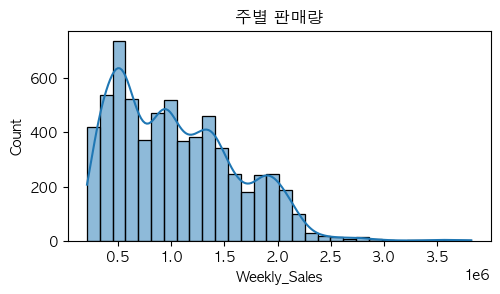

In [7]:
# 주 판매량 
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(df['Weekly_Sales'], bins=30, kde=True)
plt.title('주별 판매량')
plt.show()

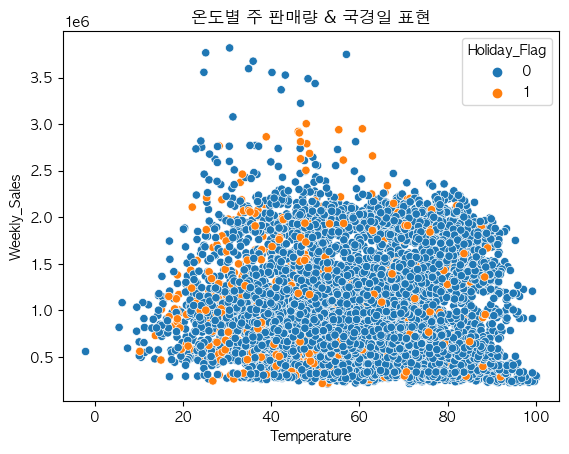

In [8]:
# 온도별 주 판매량 & 국경일 시각화 (주황색 국경일)
sns.scatterplot(data=df, x='Temperature', y='Weekly_Sales', hue='Holiday_Flag')
plt.title('온도별 주 판매량 & 국경일 표현')
plt.show()

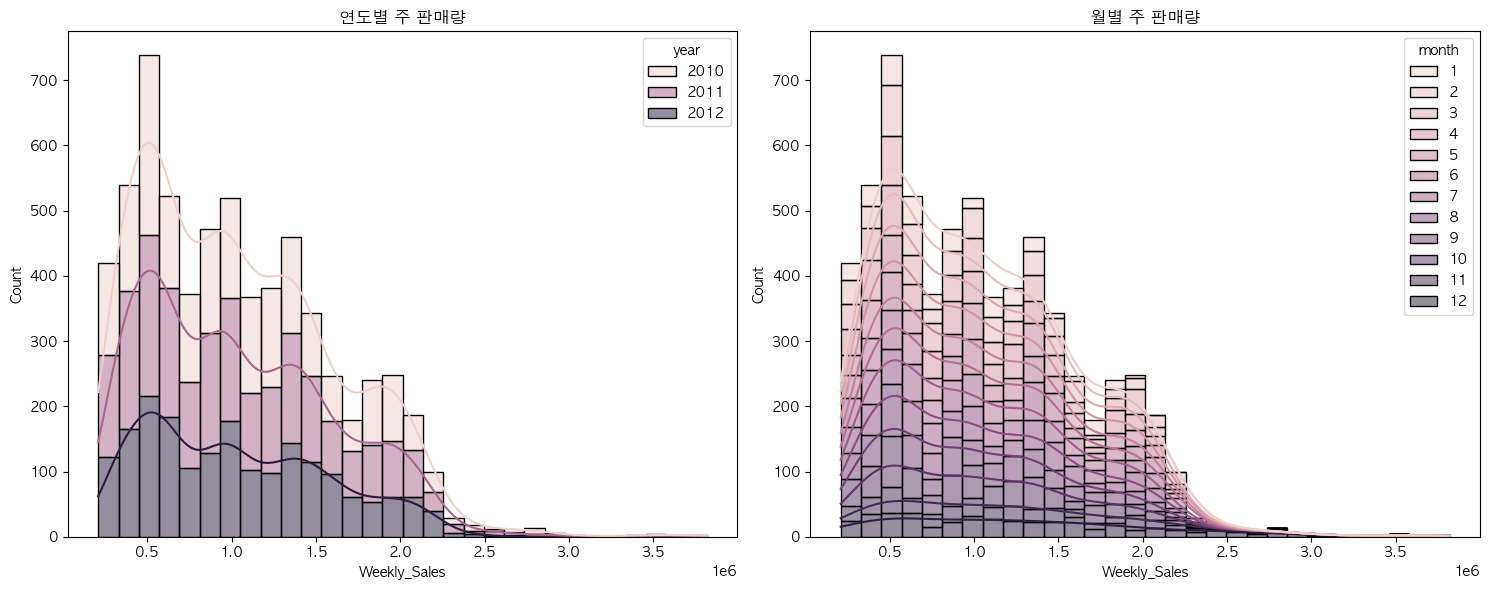

In [9]:
# 연도별 주 판매량
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Weekly_Sales', hue='year', bins=30, kde=True, multiple='stack')
plt.title('연도별 주 판매량')

# 월별 주 판매량 
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='Weekly_Sales', hue='month', bins=30, kde=True, multiple='stack')
plt.title('월별 주 판매량')

plt.tight_layout()
plt.show()

In [10]:
#연도와 월별 판매량 내림차순으로 40위까지 정렬
df[['Weekly_Sales','year','month']].value_counts()[:40].head(40)

Weekly_Sales  year  month
209986.25     2010  12       1
1277882.77    2011  10       1
1280414.80    2010  6        1
1280231.85    2010  4        1
1280156.47    2010  7        1
1279819.43    2010  3        1
1279666.47    2010  9        1
1279623.26    2012  1        1
1279080.58    2012  9        1
1279041.64    2012  9        1
1278304.33    2011  5        1
1277959.42    2011  5        1
1277758.76    2012  4        1
1288823.72    2010  4        1
1277150.60    2010  11       1
1276609.36    2012  9        1
1276031.84    2010  7        1
1275597.85    2011  9        1
1275591.84    2010  9        1
1275146.94    2010  12       1
1274463.02    2011  10       1
1273670.32    2011  4        1
1273295.46    2010  9        1
1273279.79    2010  7        1
1280465.80    2010  4        1
1280958.97    2011  9        1
1281675.60    2010  11       1
1282320.05    2011  11       1
1287899.41    2012  4        1
1287288.59    2010  5        1
1287034.70    2011  1        1
1286833.62   

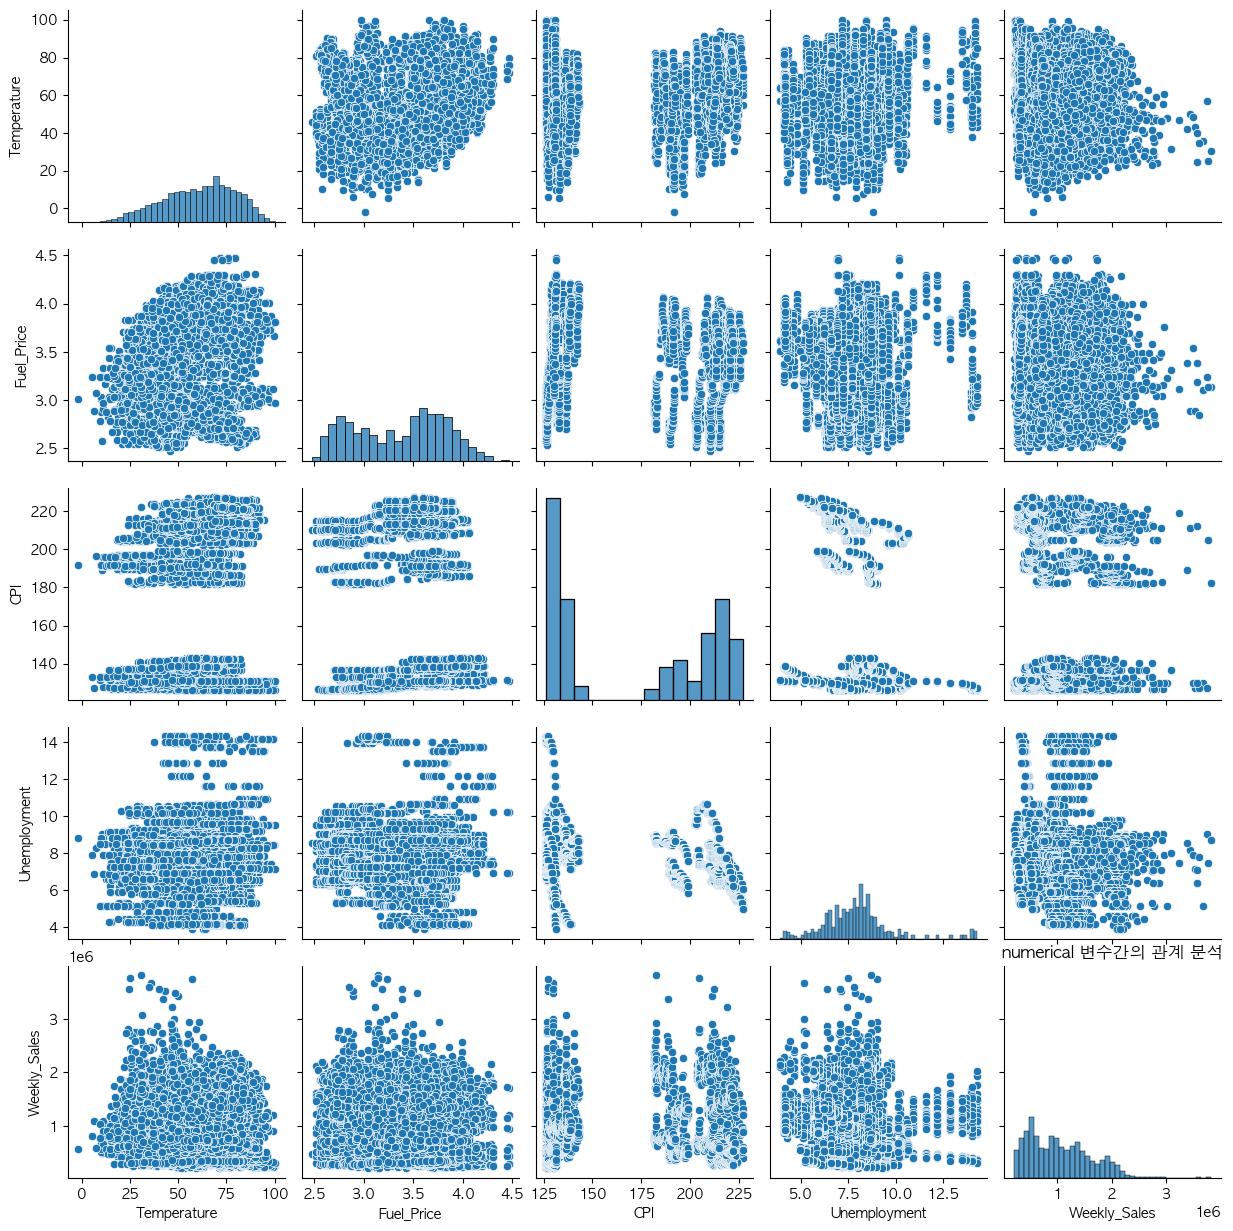

In [11]:
# numerical 변수들의 관계를 파악하는 pair plot ('Temperature', 'Fuel_Price', 'CPI', 'Unemployment','Weekly_Sales')
numerical_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
sns.pairplot(df[numerical_features + [target]])
plt.title('numerical 변수간의 관계 분석')
plt.show()

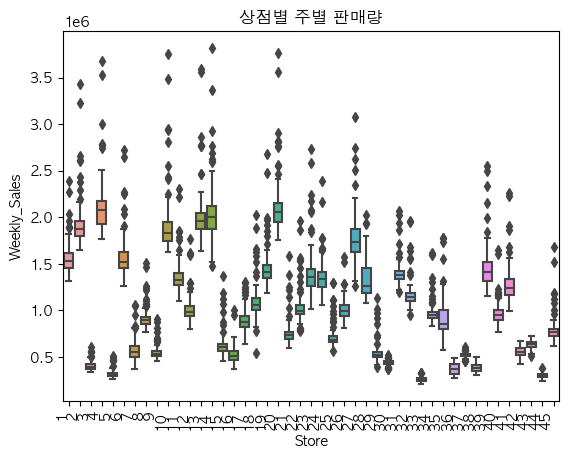

In [12]:
#상점별 주별 판매량 
plt.xticks(rotation=90)
sns.boxplot(x='Store', y=target, data=df)
plt.title('상점별 주별 판매량')
plt.xticks(rotation=90, ha='right')
plt.show()

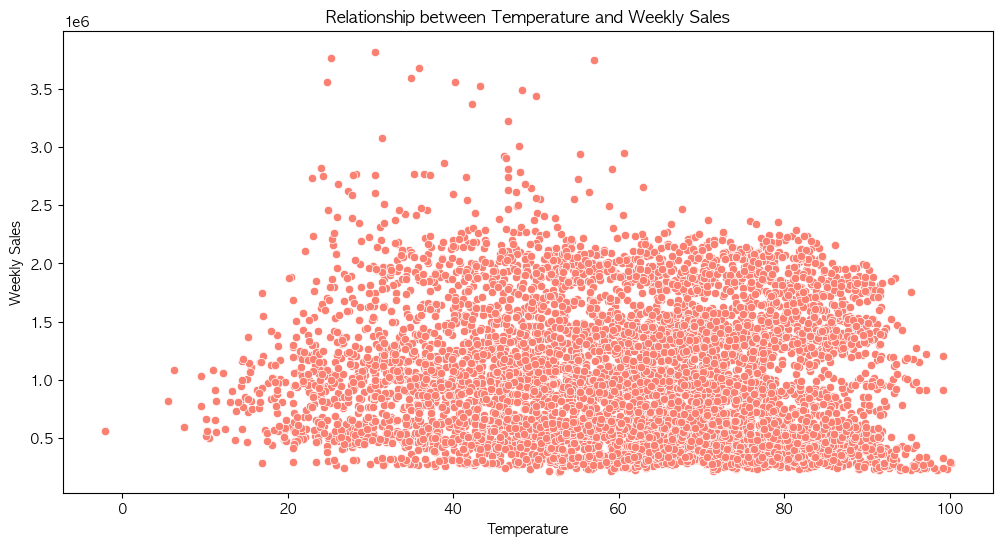

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=df, color='salmon')
plt.title('Relationship between Temperature and Weekly Sales')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.show()

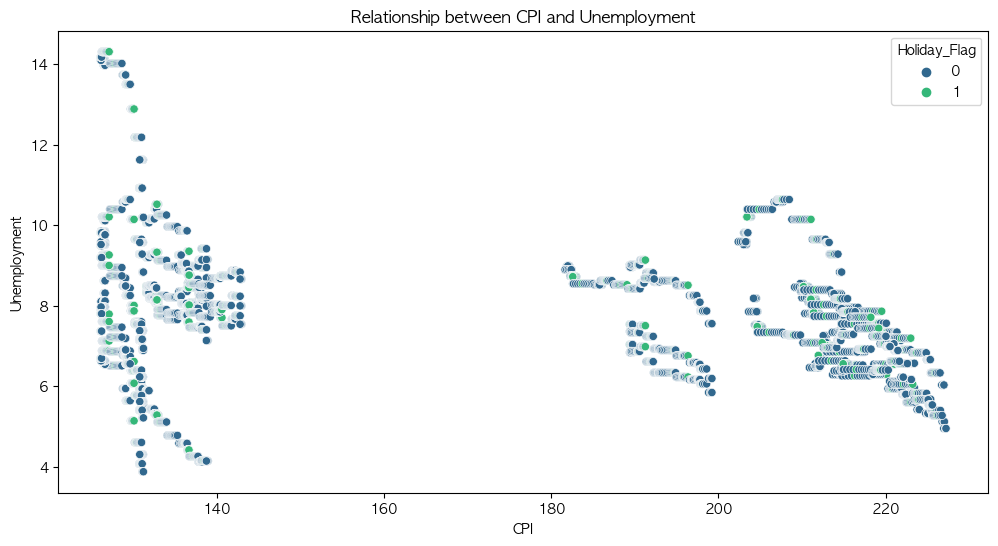

In [14]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='CPI', y='Unemployment', data=df, hue='Holiday_Flag', palette='viridis')
plt.title('Relationship between CPI and Unemployment')
plt.xlabel('CPI')
plt.ylabel('Unemployment')
plt.show()

<Figure size 4000x3500 with 0 Axes>

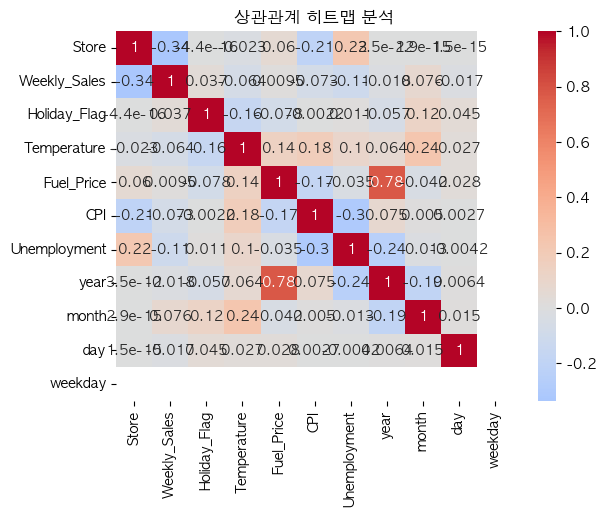

<Figure size 4000x3500 with 0 Axes>

In [15]:
# 정규화 하기 전 변수간 상관관계 히트맵 분석
plt.title('상관관계 히트맵 분석')
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.figure(figsize=(40,35))

# 원핫 인코딩

In [16]:
df = pd.get_dummies(df, columns=['year', 'weekday', 'month', 'Store'], drop_first=True)

In [17]:
# 이상치 제거
for feature in df.columns:
    if df[feature].nunique() > 45:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        df = df[(df[feature] <= (Q3 + 1.5 * IQR)) & (df[feature] >= (Q1 - 1.5 * IQR))].reset_index(drop=True)

# 정규화

In [18]:
# Standardization
m = []
for i in df.columns.values:
    m.append(i.replace(' ', '_'))

df.columns = m
X = df.drop([target], axis=1)
Y = df[target]

Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True, inplace=True)

In [19]:
# Feature Scaling (Standardization)
std = StandardScaler()

print('Standardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

                                            Standardization on Training set                                             


Holiday_Flag   Temperature    Fuel_Price           CPI  Unemployment  \
count  4.733000e+03  4.733000e+03  4.733000e+03  4.733000e+03  4.733000e+03   
mean   3.377818e-17  2.371979e-16  1.501252e-17  8.482076e-17  1.131944e-15   
std    1.000106e+00  1.000106e+00  1.000106e+00  1.000106e+00  1.000106e+00   
min   -2.759909e-01 -2.857034e+00 -1.876247e+00 -1.256640e+00 -2.772559e+00   
25%   -2.759909e-01 -7.329980e-01 -9.814720e-01 -1.083322e+00 -6.762345e-01   
50%   -2.759909e-01  1.161832e-01  1.674012e-01  3.826516e-01  9.260667e-02   
75%   -2.759909e-01  7.839386e-01  8.341386e-01  9.948847e-01  6.261873e-01   
max    3.623308e+00  2.162233e+00  2.458632e+00  1.339849e+00  2.577799e+00   

                day     year_2011     year_2012       month_2       month_3  \
count  4.733000e+03  4.733000e+03  4.733000e+03  4.733000e+03  4.733000e+03   
mean   3.603006e-17  4.804008e-17 -2.702254e-17 -2.852379e-17  4.653882e-17   
std    1.000106e+00  1.000106e+00  1.000106e+00  1.000106e+00  1.000106e+00   
min   -1.684932e+00 -7.673253e-01 -6.362923e-01 -3.042482e-01 -3.063159e-01   
25%   -8.842968e-01 -7.673253e-01 -6.362923e-01 -3.042482e-01 -3.063159e-01   
50%    3.071465e-02 -7.673253e-01 -6.362923e-01 -3.042482e-01 -3.063159e-01   
75%    8.313497e-01  1.303228e+00  1.571605e+00 -3.042482e-01 -3.063159e-01   
max    1.746361e+00  1.303228e+00  1.571605e+00  3.286791e+00  3.264603e+00   

       ...      Store_36      Store_37      Store_38      Store_39  \
count  ...  4.733000e+03  4.733000e+03  4.733000e+03  4.733000e+03   
mean   ...  7.206011e-17  2.289410e-17  1.876565e-18  3.002505e-17   
std    ...  1.000106e+00  1.000106e+00  1.000106e+00  1.000106e+00   
min    ... -1.571008e-01 -1.626606e-01 -5.248083e-02 -1.619750e-01   
25%    ... -1.571008e-01 -1.626606e-01 -5.248083e-02 -1.619750e-01   
50%    ... -1.571008e-01 -1.626606e-01 -5.248083e-02 -1.619750e-01   
75%    ... -1.571008e-01 -1.626606e-01 -5.248083e-02 -1.619750e-01   
max    ...  6.365339e+00  6.147770e+00  1.905458e+01  6.173792e+00   

           Store_40      Store_41      Store_42      Store_43      Store_44  \
count  4.733000e+03  4.733000e+03  4.733000e+03  4.733000e+03  4.733000e+03   
mean   6.005009e-18  2.833614e-17 -2.251879e-18 -3.828193e-17  2.552129e-17   
std    1.000106e+00  1.000106e+00  1.000106e+00  1.000106e+00  1.000106e+00   
min   -1.277479e-01 -1.528115e-01 -1.563933e-01 -1.592062e-01 -1.599025e-01   
25%   -1.277479e-01 -1.528115e-01 -1.563933e-01 -1.592062e-01 -1.599025e-01   
50%   -1.277479e-01 -1.528115e-01 -1.563933e-01 -1.592062e-01 -1.599025e-01   
75%   -1.277479e-01 -1.528115e-01 -1.563933e-01 -1.592062e-01 -1.599025e-01   
max    7.827919e+00  6.544011e+00  6.394134e+00  6.281162e+00  6.253812e+00   

           Store_45  
count  4.733000e+03  
mean  -9.007514e-18  
std    1.000106e+00  
min   -1.556829e-01  
25%   -1.556829e-01  
50%   -1.556829e-01  
75%   -1.556829e-01  
max    6.423311e+00  

[8 rows x 63 columns]

In [20]:
print('\n', 'Standardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())


                                              Standardization on Testing set                                             


Holiday_Flag  Temperature   Fuel_Price          CPI  Unemployment  \
count   1184.000000  1184.000000  1184.000000  1184.000000   1184.000000   
mean      -0.032285     0.059194     0.050174    -0.000536     -0.061199   
std        0.944269     0.977151     0.974268     1.007606      1.024192   
min       -0.275991    -2.522344    -1.772001    -1.256640     -2.772559   
25%       -0.275991    -0.612905    -0.875055    -1.086583     -0.731209   
50%       -0.275991     0.176839     0.297708     0.390975      0.056226   
75%       -0.275991     0.792739     0.846083     0.996458      0.597083   
max        3.623308     2.027924     2.458632     1.338222      2.577799   

               day    year_2011    year_2012      month_2      month_3  ...  \
count  1184.000000  1184.000000  1184.000000  1184.000000  1184.000000  ...   
mean     -0.048885    -0.045080     0.090971    -0.019149     0.085761  ...   
std       1.009338     0.987235     1.038133     0.971246     1.116873  ...   
min      -1.684932    -0.767325    -0.636292    -0.304248    -0.306316  ...   
25%      -0.998673    -0.767325    -0.636292    -0.304248    -0.306316  ...   
50%       0.030715    -0.767325    -0.636292    -0.304248    -0.306316  ...   
75%       0.831350     1.303228     1.571605    -0.304248    -0.306316  ...   
max       1.746361     1.303228     1.571605     3.286791     3.264603  ...   

          Store_36     Store_37     Store_38     Store_39     Store_40  \
count  1184.000000  1184.000000  1184.000000  1184.000000  1184.000000   
mean      0.002655    -0.050736     0.012070    -0.044250     0.033516   
std       1.008630     0.833279     1.109166     0.855944     1.121613   
min      -0.157101    -0.162661    -0.052481    -0.161975    -0.127748   
25%      -0.157101    -0.162661    -0.052481    -0.161975    -0.127748   
50%      -0.157101    -0.162661    -0.052481    -0.161975    -0.127748   
75%      -0.157101    -0.162661    -0.052481    -0.161975    -0.127748   
max       6.365339     6.147770    19.054577     6.173792     7.827919   

          Store_41     Store_42     Store_43     Store_44     Store_45  
count  1184.000000  1184.000000  1184.000000  1184.000000  1184.000000  
mean      0.045152     0.009583    -0.017779    -0.024478     0.016571  
std       1.134735     1.029844     0.944242     0.922472     1.050961  
min      -0.152811    -0.156393    -0.159206    -0.159902    -0.155683  
25%      -0.152811    -0.156393    -0.159206    -0.159902    -0.155683  
50%      -0.152811    -0.156393    -0.159206    -0.159902    -0.155683  
75%      -0.152811    -0.156393    -0.159206    -0.159902    -0.155683  
max       6.544011     6.394134     6.281162     6.253812     6.423311  

[8 rows x 63 columns]

                                       Correlation Matrix                                       


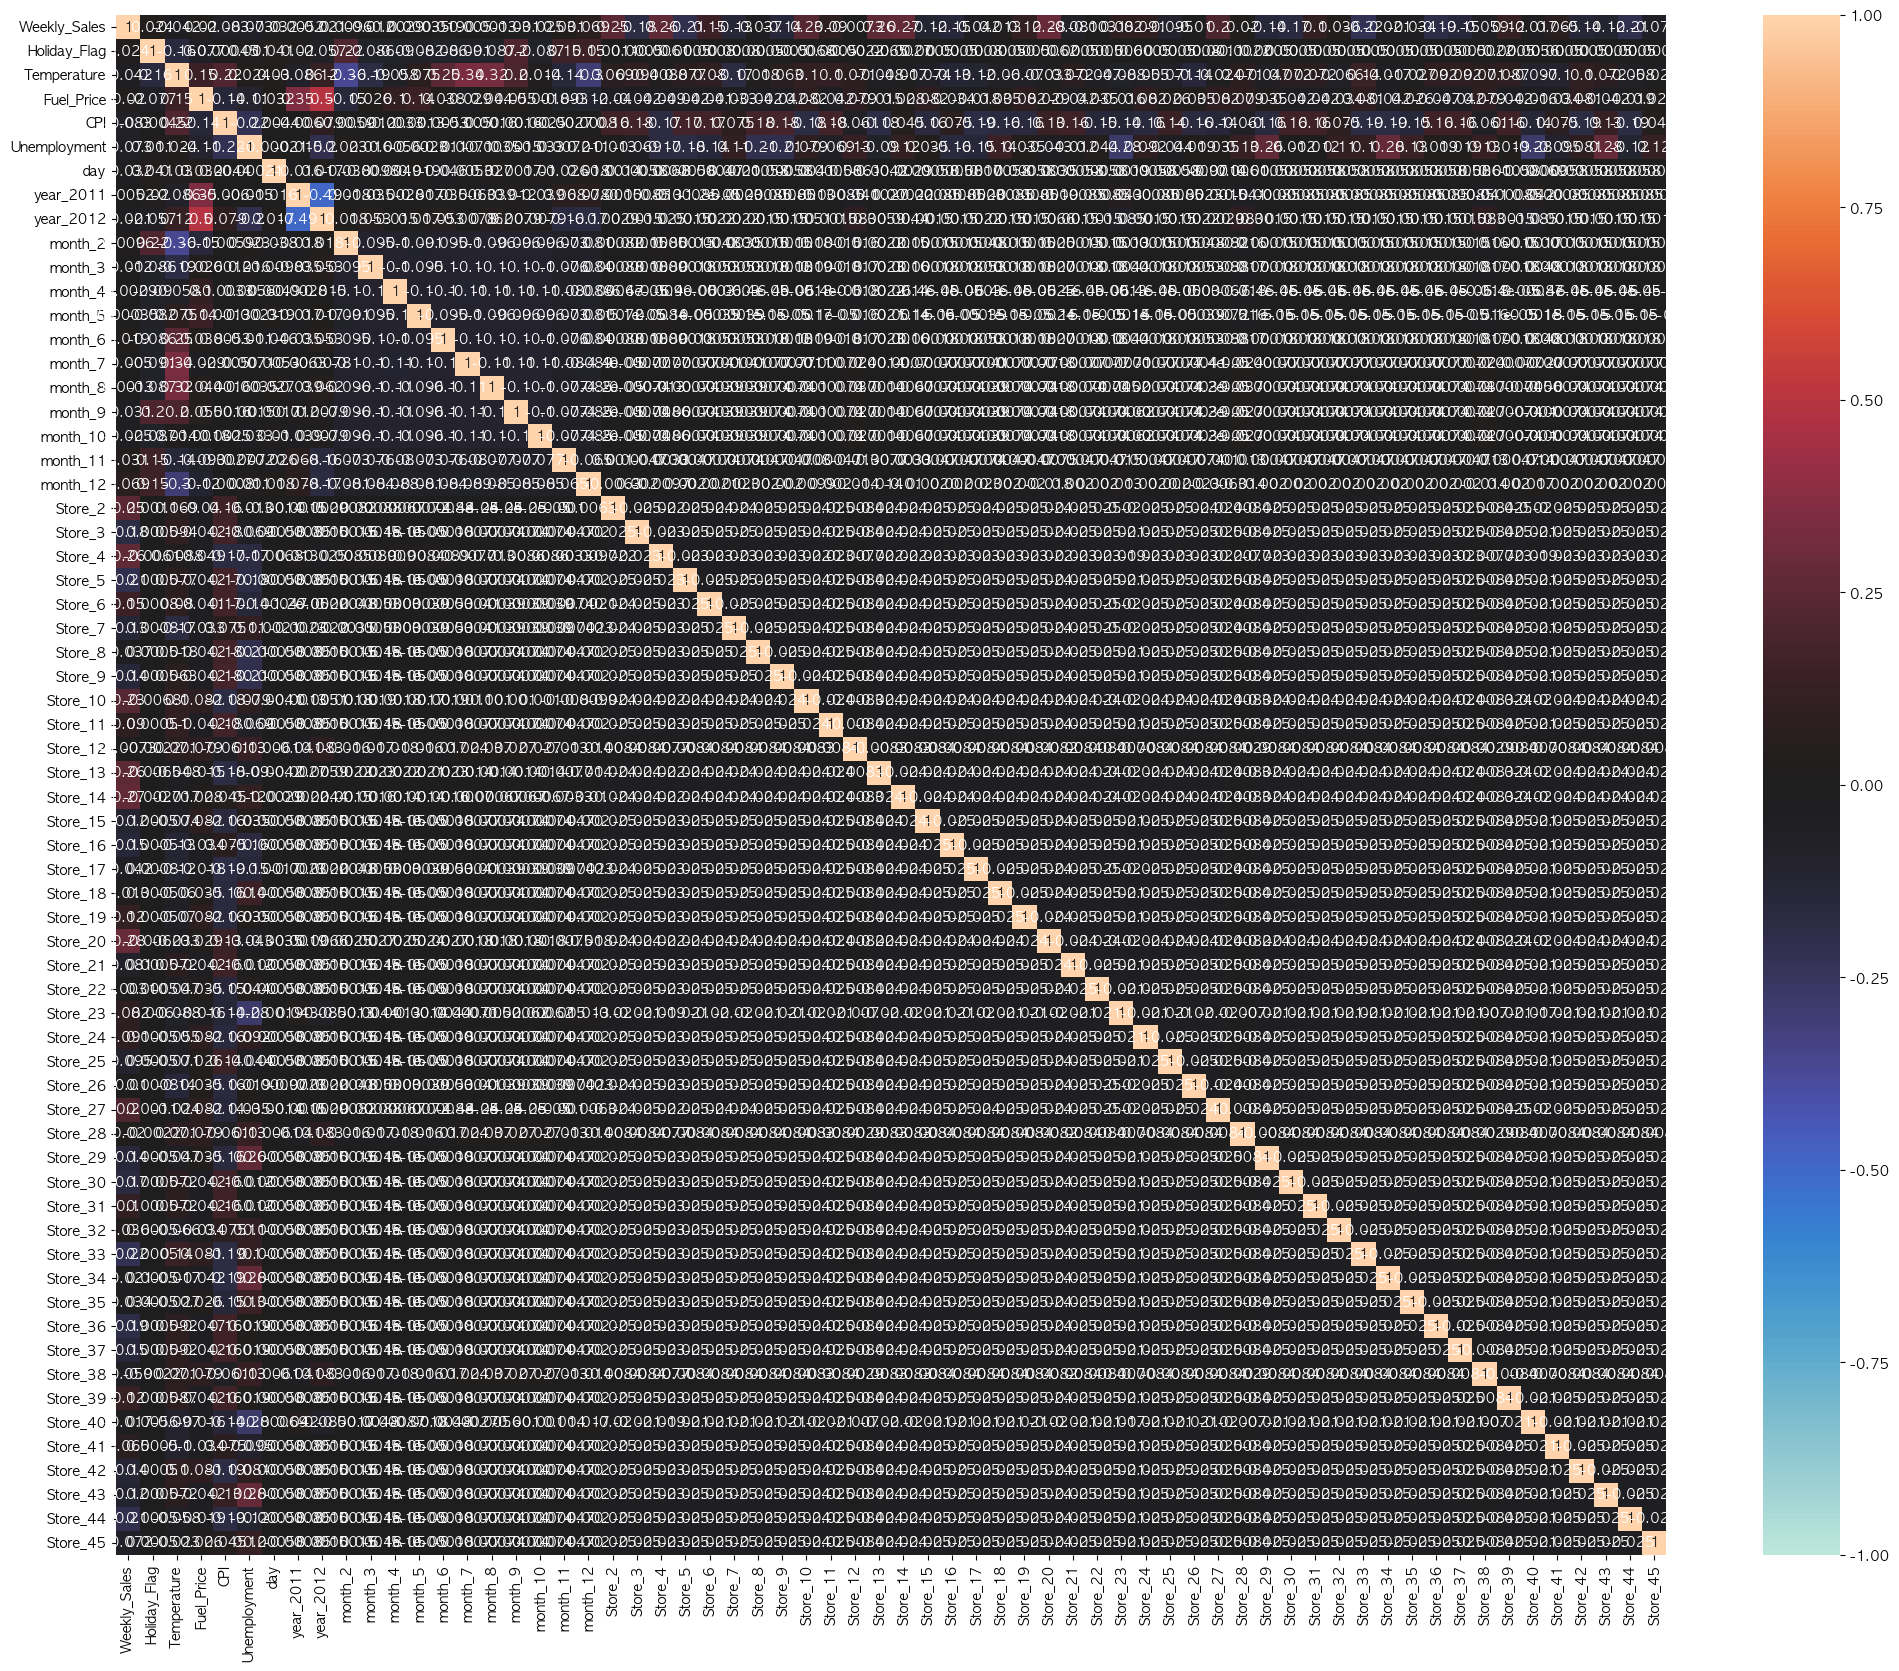

In [21]:
#정규화 후 상과관계 분석
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

# 모델학습

In [22]:
model = LinearRegression()
model.fit(Train_X_std, Train_Y)

LinearRegression()

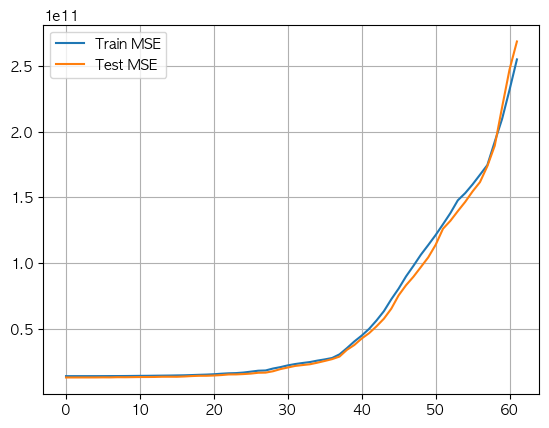

In [23]:
Trr = [] 
Tss = [] 
n = 3 
order = [f'ord-{i}' for i in range(2, n)]
Trd = pd.DataFrame(np.zeros((10, n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10, n-2)), columns=order)

m = df.shape[1] - 2 
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm, n_features_to_select=Train_X_std.shape[1] - i)
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:, rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:, rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:, rfe.support_])

    Trr.append(mean_squared_error(Train_Y, pred1))
    Tss.append(mean_squared_error(Test_Y, pred2))

plt.plot(Trr, label='Train MSE')
plt.plot(Tss, label='Test MSE')
plt.legend()
plt.grid()
plt.show()


In [24]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}')
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}')
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}')
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

# 선형회귀

Evaluating Multiple Linear Regression Model
The Intercept of the Regresion Model was found to be  1038339.4693471373


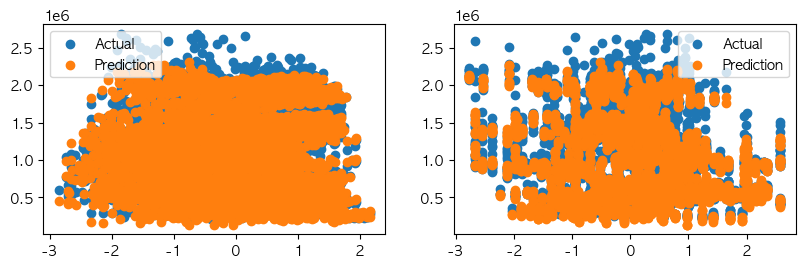



{}Training Set Metrics{}

R2-Score on Training set ---> 0.9517977643050008
Residual Sum of Squares (RSS) on Training set  ---> 68896821497207.234
Mean Squared Error (MSE) on Training set       ---> 14556691632.623543
Root Mean Squared Error (RMSE) on Training set ---> 120651.11533932682

{}Testing Set Metrics{}

R2-Score on Testing set ---> 0.9570091299004272
Residual Sum of Squares (RSS) on Training set  ---> 16032112423573.502
Mean Squared Error (MSE) on Training set       ---> 13540635492.883026
Root Mean Squared Error (RMSE) on Training set ---> 116364.23631375332

{}Residual Plots{}


/var/folders/24/kj6qhrn550xbr18__b59pv440000gn/T/ipykernel_32555/530028937.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((Train_Y - pred1))


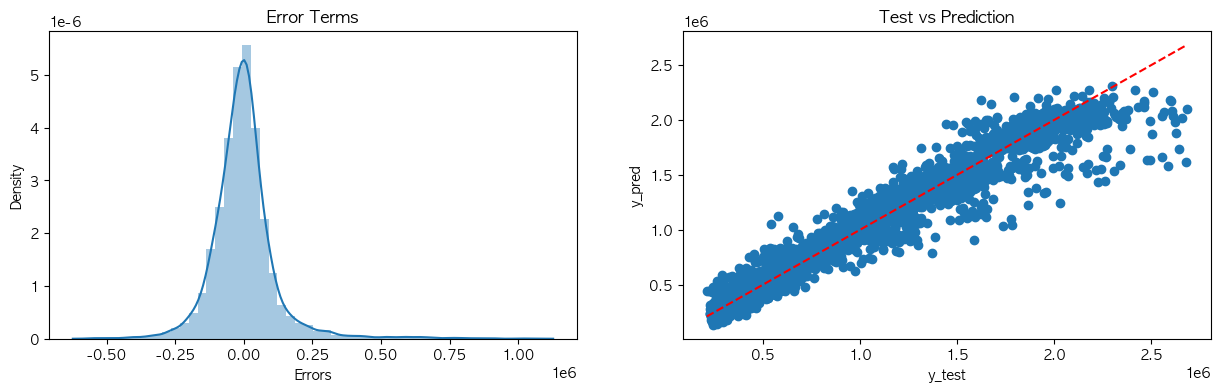

In [25]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('Evaluating Multiple Linear Regression Model')
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

# ridge 모델

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1038339.4693471373


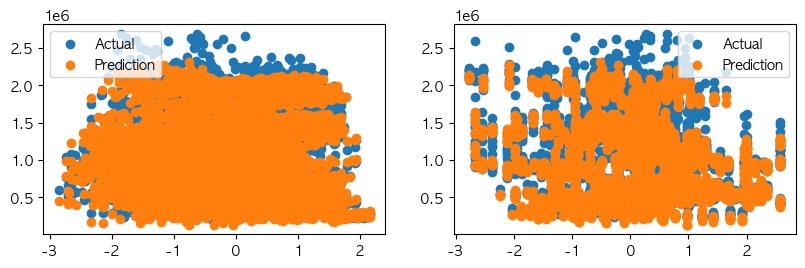



{}Training Set Metrics{}

R2-Score on Training set ---> 0.9517965816649764
Residual Sum of Squares (RSS) on Training set  ---> 68898511878109.35
Mean Squared Error (MSE) on Training set       ---> 14557048780.500603
Root Mean Squared Error (RMSE) on Training set ---> 120652.5954155177

{}Testing Set Metrics{}

R2-Score on Testing set ---> 0.957042593183328
Residual Sum of Squares (RSS) on Training set  ---> 16019633329470.8
Mean Squared Error (MSE) on Training set       ---> 13530095717.458447
Root Mean Squared Error (RMSE) on Training set ---> 116318.93963348553

{}Residual Plots{}


/var/folders/24/kj6qhrn550xbr18__b59pv440000gn/T/ipykernel_32555/530028937.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((Train_Y - pred1))


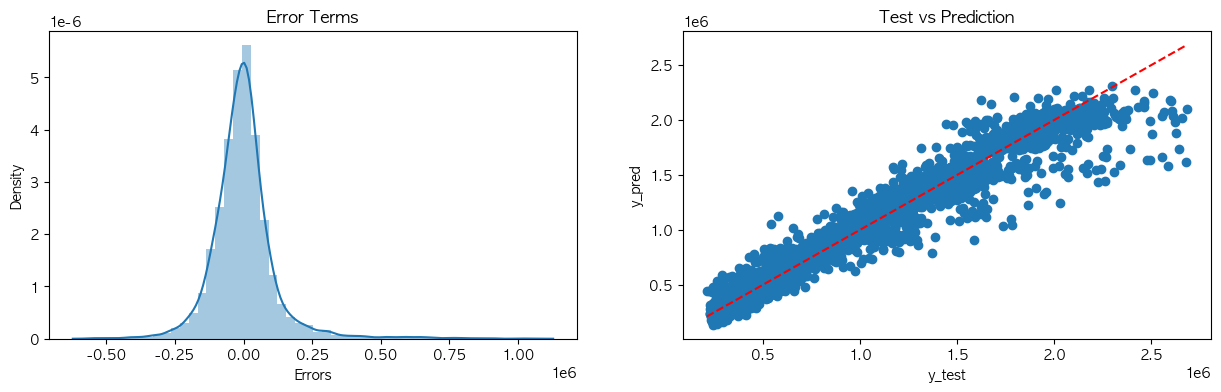

In [26]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

# lasso 모델

/Users/yeong-gwang/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.741e+13, tolerance: 1.429e+11
  model = cd_fast.enet_coordinate_descent(


<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1038339.4693471373


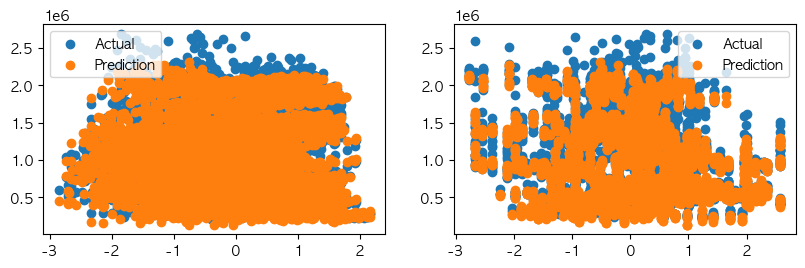



{}Training Set Metrics{}

R2-Score on Training set ---> 0.9517966240281239
Residual Sum of Squares (RSS) on Training set  ---> 68898451327262.086
Mean Squared Error (MSE) on Training set       ---> 14557035987.167143
Root Mean Squared Error (RMSE) on Training set ---> 120652.54239827333

{}Testing Set Metrics{}

R2-Score on Testing set ---> 0.9570368248712017
Residual Sum of Squares (RSS) on Training set  ---> 16021784442679.033
Mean Squared Error (MSE) on Training set       ---> 13531912536.04648
Root Mean Squared Error (RMSE) on Training set ---> 116326.74901348563

{}Residual Plots{}


/var/folders/24/kj6qhrn550xbr18__b59pv440000gn/T/ipykernel_32555/530028937.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((Train_Y - pred1))


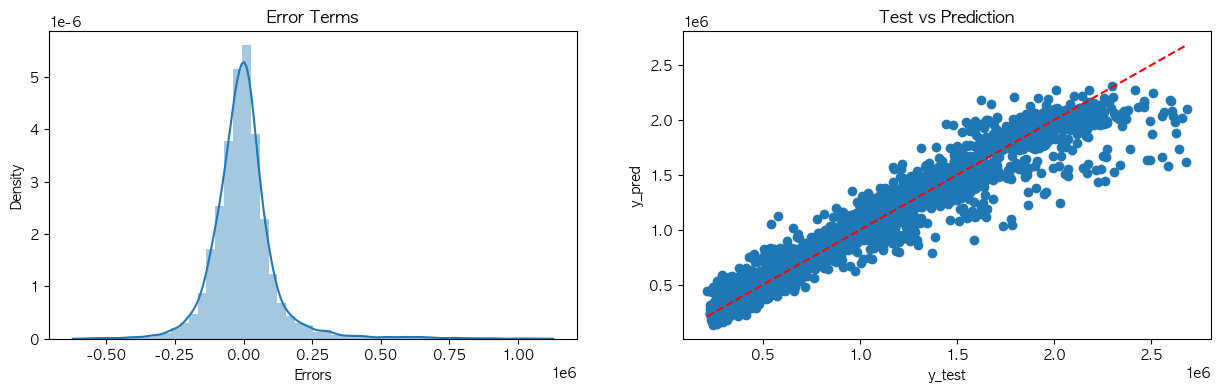

In [27]:

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

#  ElasticNet Regression 모델

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1038339.4693471373


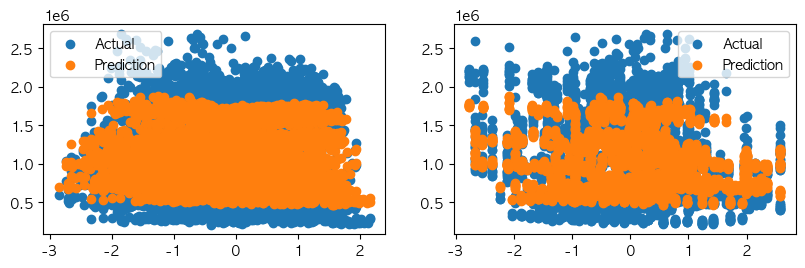



{}Training Set Metrics{}

R2-Score on Training set ---> 0.8290794283148832
Residual Sum of Squares (RSS) on Training set  ---> 244301616881471.88
Mean Squared Error (MSE) on Training set       ---> 51616652626.55227
Root Mean Squared Error (RMSE) on Training set ---> 227192.98542550183

{}Testing Set Metrics{}

R2-Score on Testing set ---> 0.8397626270813174
Residual Sum of Squares (RSS) on Training set  ---> 59755561381762.19
Mean Squared Error (MSE) on Training set       ---> 50469224140.00185
Root Mean Squared Error (RMSE) on Training set ---> 224653.564716881

{}Residual Plots{}


/var/folders/24/kj6qhrn550xbr18__b59pv440000gn/T/ipykernel_32555/530028937.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((Train_Y - pred1))


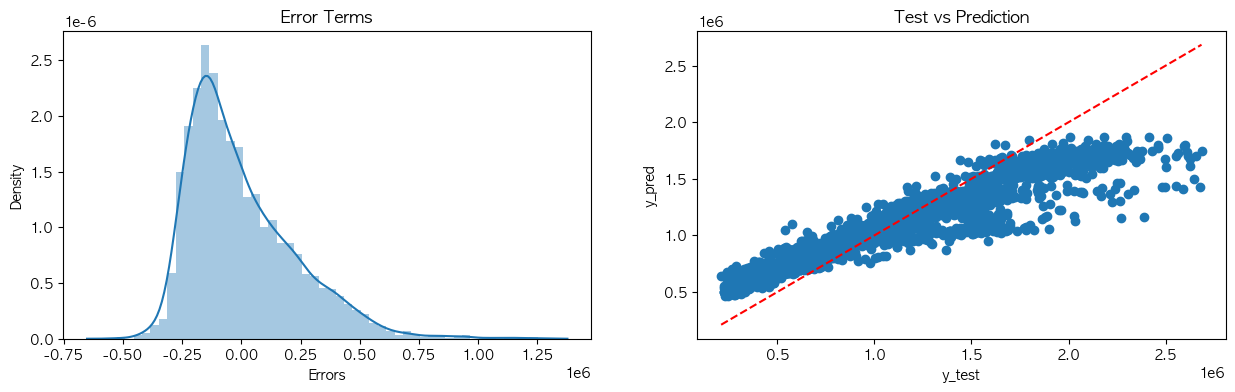

In [28]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [  10577.94282505   31469.83920875   -4348.89954904  125828.24709583
  -47161.26343185  -12676.27776919   -9837.64237873  -18844.05506486
   28381.61943425   16425.97832737   19155.20492159   15580.45945012
   19594.52228591    7781.12332565   12764.92158008   -4483.65172484
    4029.72662329   36929.00095759   71418.59915624   53288.84863711
 -181321.78531167  100949.60083384 -186682.97485082   -8351.88642816
 -130046.74164025 -111643.0912569  -161238.13751457   84641.92568755
  -36725.0576822    -8515.52146004  100064.81896459   88384.73311531
  -99811.24379493 -147100.9918512   -59852.29601561  -21162.96271586
   29094.97308343   81344.46094905 -126213.01589088  -38137.2331497
    2252.91353189   14893.4246116  -128865.03094449  -37640.67353755
   74915.63208296    7439.19682725 -101590.99294569 -178369.72895007

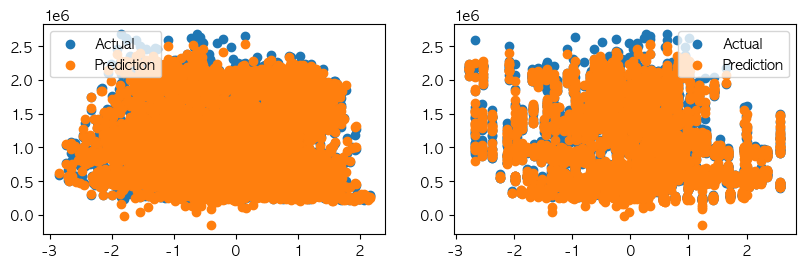



{}Training Set Metrics{}

R2-Score on Training set ---> 0.9874786097252105
Residual Sum of Squares (RSS) on Training set  ---> 17897177967380.883
Mean Squared Error (MSE) on Training set       ---> 3781360229.7445345
Root Mean Squared Error (RMSE) on Training set ---> 61492.7656699919

{}Testing Set Metrics{}

R2-Score on Testing set ---> 0.9785129962361564
Residual Sum of Squares (RSS) on Training set  ---> 8012912025037.37
Mean Squared Error (MSE) on Training set       ---> 6767662183.308588
Root Mean Squared Error (RMSE) on Training set ---> 82265.80202799088

{}Residual Plots{}


/var/folders/24/kj6qhrn550xbr18__b59pv440000gn/T/ipykernel_32555/530028937.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((Train_Y - pred1))


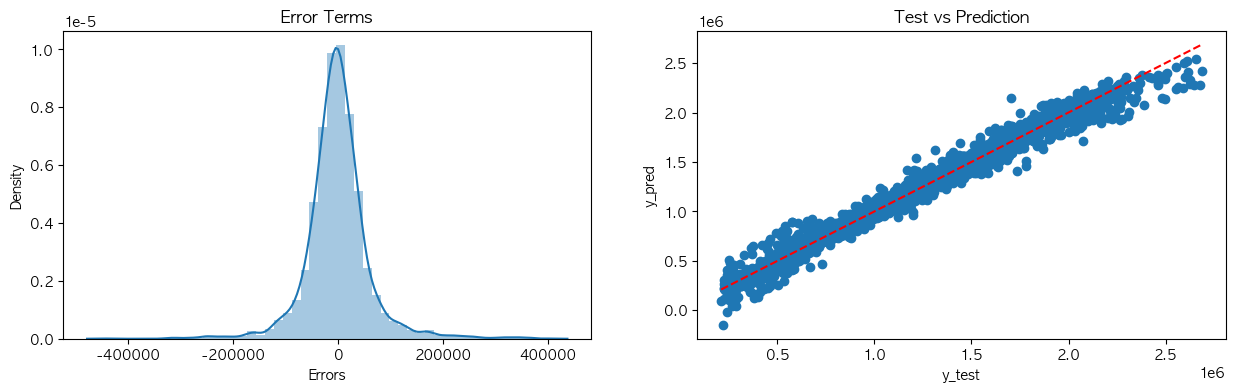

In [29]:
#Using the 2nd Order Polynomial Regression model (degree=2)

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

In [30]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

Train-R2   Test-R2     Train-RSS  \
Multiple Linear Regression (MLR)  0.951798  0.957009  6.889682e+13   
Ridge Linear Regression (RLR)     0.951797  0.957043  6.889851e+13   
Lasso Linear Regression (LLR)     0.951797  0.957037  6.889845e+13   
Elastic-Net Regression (ENR)      0.829079  0.839763  2.443016e+14   
Polynomial Regression (PNR)       0.987479  0.978513  1.789718e+13   

                                      Test-RSS     Train-MSE      Test-MSE  \
Multiple Linear Regression (MLR)  1.603211e+13  1.455669e+10  1.354064e+10   
Ridge Linear Regression (RLR)     1.601963e+13  1.455705e+10  1.353010e+10   
Lasso Linear Regression (LLR)     1.602178e+13  1.455704e+10  1.353191e+10   
Elastic-Net Regression (ENR)      5.975556e+13  5.161665e+10  5.046922e+10   
Polynomial Regression (PNR)       8.012912e+12  3.781360e+09  6.767662e+09   

                                     Train-RMSE      Test-RMSE  
Multiple Linear Regression (MLR)  120651.115339  116364.236314  
Ridge Linear Regression (RLR)     120652.595416  116318.939633  
Lasso Linear Regression (LLR)     120652.542398  116326.749013  
Elastic-Net Regression (ENR)      227192.985426  224653.564717  
Polynomial Regression (PNR)        61492.765670   82265.802028

# 회귀 모델들의 결정계수 요약

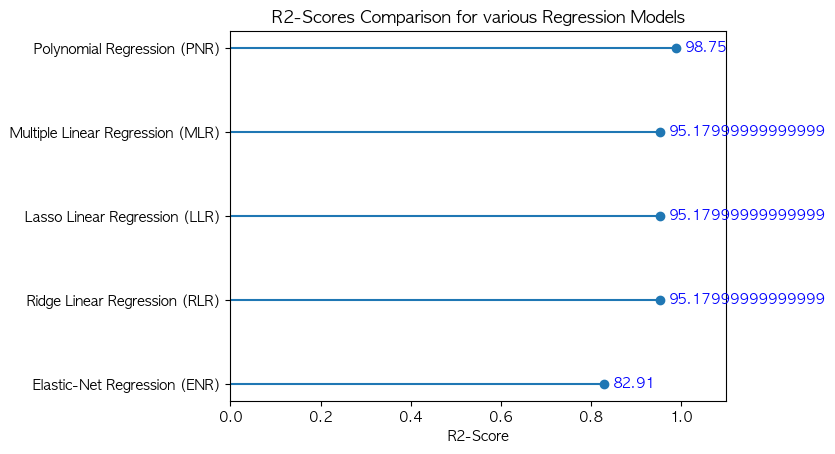

In [31]:
# R2-Scores Comparison for different Regression Models

R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

# 결론


- polynomial 회귀는 과적합된 것으로 나타났으며, 여러 알고리즘 중 Multiple Linear 회귀 알고리즘을 사용하는 것이 가장 높은 정확도를 제공했다.

- R2_test는 다중선형회귀, lasso선형회귀, ridge선형회귀를 사용했을 때 값이 95.17999로 가장 높았다.